# CS 3110/5110: Data Privacy
## FINAL PROJECT - Harry Sharman, Ryan Symons

* In this projects we will be using a new data set - students.csv - which has columns such as GPA, student ID, email, etc., and we will be using laplace and guassian to keep differential privacy and analyze the results
* On a secondary discourse, we will look at how laplace and gaussian preform, and decide which is more efficient for our data set
* We included histograns to show a visual representation of our findings
* Lastly, we preformed an averaging attack using both sequential and advanced composition

In [8]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def laplace_mech_vec(qs, sensitivity, epsilon):
    return [laplace_mech(q, sensitivity, epsilon) for q in qs]

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(qs, sensitivity, epsilon, delta):
    return [gaussian_mech(q, sensitivity, epsilon, delta) for q in qs]

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

student = pd.read_csv('students.csv')

## Test laplace and gaussian mechanisms on the data set, and compare them with the original

In [9]:
def query1():
    return len(student[student['Department'] == 'Mathematics'])

query1()

30

In [116]:
def dp_laplace_query1(epsilon):
    return laplace_mech(query1(), sensitivity=1,epsilon=epsilon)

dp_laplace_query1(0.1)

28.76558088647868

In [117]:
def dp_gaussian_query1(epsilon, delta):
    return gaussian_mech(query1(),sensitivity=1,epsilon=epsilon,delta=delta)

dp_gaussian_query1(0.1, 10e-5)

17.69225015889777

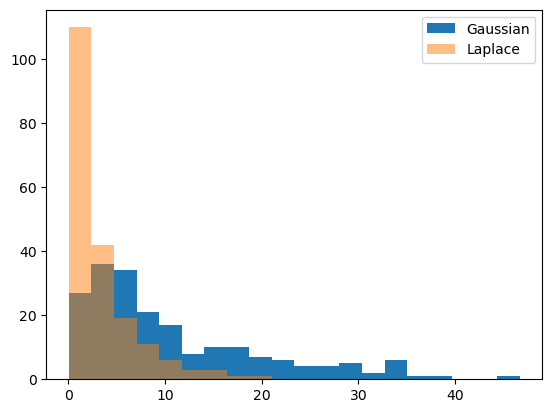

In [126]:
actual_answers = len(student[student['Department'] == 'Mathematics'])

laplace_answers = [laplace_mech(actual_answers, 1, 1) for _ in range(200)]
gaussian_answers = [gaussian_mech(actual_answers, 1, 1, 10e-5) for _ in range(200)]

laplace_error = [pct_error(actual_answers, a) for a in laplace_answers]
gaussian_error = [pct_error(actual_answers, a) for a in gaussian_answers]

_, bins, _ = plt.hist(gaussian_error, bins=20, label = 'Gaussian')
plt.hist(laplace_error, bins=bins, label='Laplace', alpha = 0.5)
plt.legend();


# ^^^^EXPLAIN THE ABOVE JOEN^^^

In the above histogram, graphing laplace and gaussian errors, the laplace mechanism has a higher frequency of lower error and the gaussian mechanism has lower frequency of each error (with a higher distribution of error values).

This means that since the distribution of the laplace mechanism is centered more toward 0, the preservation of accuracy for our dataset is higher compared to that of the gaussian mechanism.

Since the distribution of the gaussian mechanism is greater, it causes more noise to be added to the queries and in turn 'protecting' privacy 'more' than that of the laplace mechanism.

## Question 1 (5 points)

Implement the `dp_occupation_histogram` function below. It should return a differentially private histogram over the `Occupation` column in the `adult` dataset. Your function should have a total privacy cost of `epsilon` and should use parallel composition.

In [2]:
def dp_occupation_histogram(epsilon):
    occupation_counts = adult['Occupation'].value_counts()
    sensitivity = 1
    dp_counts = occupation_counts.apply(lambda count: laplace_mech(count, sensitivity, epsilon))

    return dp_counts

dp_occupation_histogram(1.0)

Prof-specialty       4139.943721
Craft-repair         4099.726735
Exec-managerial      4066.572572
Adm-clerical         3768.547655
Sales                3650.068690
Other-service        3294.984203
Machine-op-inspct    2001.428708
Transport-moving     1595.135689
Handlers-cleaners    1371.751072
Farming-fishing       993.951059
Tech-support          929.448099
Protective-serv       648.237717
Priv-house-serv       149.506246
Armed-Forces            8.150390
Name: Occupation, dtype: float64

In [3]:
# TEST CASE
hist = adult['Occupation'].value_counts()
dp_results = [np.abs(dp_occupation_histogram(1.0)-hist) for _ in range(200)]
all_dp_results = [item for sublist in dp_results for item in sublist]
spec = [np.random.laplace(loc=0, scale=1/1.0) for _ in range(2000)]
assert stats.wasserstein_distance(all_dp_results, spec) < 2
assert stats.wasserstein_distance(all_dp_results, spec) > 0

dp_results = [np.abs(dp_occupation_histogram(0.01)-hist) for _ in range(200)]
all_dp_results = [item for sublist in dp_results for item in sublist]
spec = [np.random.laplace(loc=0, scale=1/0.01) for _ in range(2000)]
assert stats.wasserstein_distance(all_dp_results, spec) < 150
assert stats.wasserstein_distance(all_dp_results, spec) > 50

## Question 2 (10 points)

In 2-5 sentences each, answer the following:

- Argue that your solution for `dp_occupation_histogram` satisfies `epsilon`-differential privacy.
- How would your results change (in terms of accuracy) if you used sequential composition instead of parallel composition to implement `dp_occupation_histogram`, and why?
- If you partition the data by *both* occupation and age (i.e. a contingency table), would parallel composition still apply? Why or why not?
- If you partition the data by both occupation and age, what would happen to accuracy, and why?

- `dp_occupation_histogram` uses the laplace mechanism and parallel composition. We use the entire epsilon budget.
- In sequential composition, there would be an accuracy decrease. The noise added to each occupation count would have a larger scale. 
- No, for parallel composition, the queries need to be disjoint. In the contigency table this would not be the case because an individual can contribute to both occupation and age.
- There would be increased noise. The number of queries will increase, and to maintain epsilon dp, the privacy budget would need to be divided accross more queries. 

## Question 3 (5 points)

Consider the code below, which graphs the total privacy cost of an averaging attack under (1) sequential composition and (2) advanced composition, for values of `k` between 1 and 200.

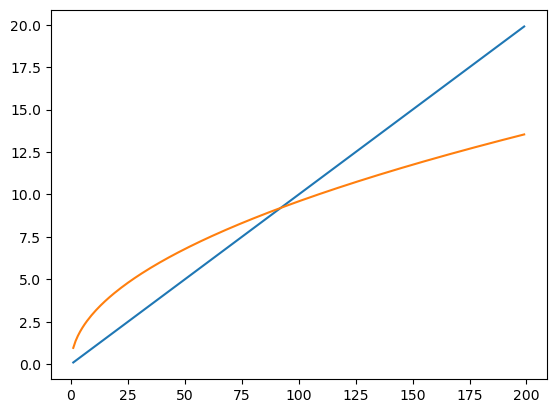

In [4]:
epsilon = .1
delta_p = 1e-5

def query():
    return len(adult_data[adult_data['Martial Status'] == 'Divorced'])

def avg_attack(k):
    return np.mean([laplace_mech(query(), 1, epsilon) for i in range(k)])
    
xs = range(1, 200)
privacy_cost_sequential = [k * epsilon for k in xs]
privacy_cost_advanced = [2 * epsilon * np.sqrt(2 * k * np.log(1/delta_p)) for k in xs]

plt.plot(xs, privacy_cost_sequential);
plt.plot(xs, privacy_cost_advanced);

In 2-5 sentences, answer the following:
- At approximately what point do the lines representing the two approaches cross? What does this mean about **which** composition technique should be used for an iterative algorithm?
- The two lines represent **different** privacy costs for the **same** algorithm. How can both be correct?

- They cross at about `85`. This means that data with less that `~85` entries should use sequenial comp and data with more than that should used advanced comp
- They are both correct because sequential composition adds up privacy costs linearly. Advanced composition does not add up pivacy costs linearly and instead does it this way: `2 * epsilon * np.sqrt(2 * k * np.log(1/delta_p)`

## Question 4 (10 points)

Consider the code below, which defines three average queries and runs them on `adult_data`, using the Laplace mechanism to provide differential privacy with $\epsilon = 1$ for each query.

In [6]:
b_capgain = 10000
b_age = 3000

epsilon = 1

def query1():
    return np.sum(adult['Capital Gain'].clip(lower=0, upper=b_capgain))

def query2():
    return len(adult[adult['Education-Num'] < 10])

def query3():
    return np.sum(adult['Age'].clip(lower=0, upper=b_age))

def my_query():
    return [query1(), query2(), query3()]

my_query()

[17145231, 14754, 1256257]

In 2-5 sentences, answer the following:
- What is the $L_1$ global sensitivity of `my_query`, and why?
- What is the $L_2$ global sensitivity of `my_query`, and why?

- L1 = Maximum changes for each query added = 10,000 + 1 + 3,000 = 13,001
- L2 = sqrt(sum of squares)

## Question 5 (5 points)

In the cell below, write code to release the results of calling `my_query()` with differential privacy, without using sequential composition.

*Hint*: use `laplace_mech_vec`, but be careful of sensitivity!

In [9]:
def my_query_lap(epsilon):
    result = my_query()
    
    sensitivity = 13001
    
    dp_result = laplace_mech_vec(result, sensitivity, epsilon)
    
    return dp_result

my_query_lap(1.0)

[17141978.432148248, 28532.617396677633, 1258336.2717358768]

### Question 6 (5 points)

In the cell below, write code to release the results of `my_query()` with differential privacy, but using the Gaussian mechanism.

*Hint*: remember to use $L_2$ sensitivity

In [10]:
def my_query_gauss(epsilon, delta):
    result = my_query()
    sensitivity = 10440 # sum of squares
    dp_result = gaussian_mech_vec(result, sensitivity, epsilon, delta)
    return dp_result

my_query_gauss(1.0, 1e-5)

[17146596.577903602, 62743.49687685274, 1159331.4100442787]